## Using FAST.AI for NLP

Exploring the MIMIC III data set medical notes.

Tried working with the full dataset, but almost every training step takes many hours (~13 for initial training), predicted 14+ per epoch for fine tuning.

Instead will try to work with just 10% sample... Not sure that will work though

A few notes:
* See https://docs.fast.ai/text.transform.html#Tokenizer for details on what various artificial tokens (e.g xxup, xxmaj, etc.) mean
* To view nicely formatted documentation on the fastai library, run commands like: ` doc(learn.lr_find)`

### To Do:
* need to evalate how changing the learning rate would alter training time
* need to evalate how changing the learning rate would alter accuracy

In [21]:
from fastai.text import *
from sklearn.model_selection import train_test_split
import glob
import gc

If you want to verify that Torch can find and use your GPU, run the following code:

```python
import torch

print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
```

These next cells can be used to get an idea of the speed up provided by a GPU for some operations (from https://course.fast.ai/gpu_tutorial.html)
```python
import torch
t_cpu = torch.rand(500,500,500)
%timeit t_cpu @ t_cpu
# separate cell 
t_gpu = torch.rand(500,500,500).cuda()
%timeit t_gpu @ t_gpu
```

In [22]:
# original data set too large to work with in reasonable time due to limted GPU resources
pct_data_sample = 0.01
# how much to hold out for validation
valid_pct = 0.1

# pandas doesn't understand ~, so provide full path
base_path = Path('/home/seth/mimic')

# files used during processing - all aggregated here
notes_file = base_path/'noteevents.pickle'
lm_file = 'mimic_lm.pickle' # actual file is at base_path/lm_file but due to fastai function, have to pass file name separately
init_model_file = base_path/'mimic_fit_head'
cycles_file = base_path/'num_iterations.pickle'
lm_base_file = 'mimic_lm_fine_tuned_'
enc_file = 'mimic_fine_tuned_enc'
class_file = 'mimic_cl.pickle'

In [23]:
# if this doesn't free memory, can restart Python kernel.
# if that still doesn't work, try OS items mentioned here: https://docs.fast.ai/dev/gpu.html
def release_mem():
    gc.collect()
    torch.cuda.empty_cache()

In [24]:
# run this to see what has already been imported
#whos

### Set Random Number seed for repeatability; set Batch Size to control GPU memory

See **"Performance notes"** section below for how setting batch size impacts GPU memory

In [25]:
seed = 42
# previously used 48; worked fine but never seemed to use even half of GPU memory; 64 still on the small side
bs=48

While parsing a CSV and converting to a dataframe is pretty fast, loading a pickle file is much faster.

For load time and size comparison:
* `NOTEEVENTS.csv` is ~ 3.8GB in size
  ```
  CPU times: user 51.2 s, sys: 17.6 s, total: 1min 8s
  Wall time: 1min 47s
  ```
* `noteevents.pickle` is ~ 3.7 GB in size
  ```
  CPU times: user 2.28 s, sys: 3.98 s, total: 6.26 s
  Wall time: 6.26 s
  ```

In [26]:
%%time

orig_df = pd.DataFrame()
if os.path.isfile(notes_file):
    print('Loading noteevnt pickle file')
    orig_df = pd.read_pickle(notes_file)
else:
    print('Could not find noteevent pickle file; creating it')
    # run this the first time to covert CSV to Pickle file
    orig_df = pd.read_csv(base_path/'NOTEEVENTS.csv', low_memory=False, memory_map=True)
    orig_df.to_pickle(notes_file)

Loading noteevnt pickle file
CPU times: user 2.59 s, sys: 1.1 s, total: 3.69 s
Wall time: 3.68 s


Due to data set size and performance reasons, working with a 10% sample. Use same random see to get same results from subsequent runs.

In [27]:
df = orig_df.sample(frac=pct_data_sample, random_state=seed)

In [28]:
# if you want to free up some memory
# orig_df = None
# del orig_df
# gc.collect()

In [29]:
from pympler import asizeof
print('df:', int(asizeof.asizeof(df) / 1024 / 1024), 'MB')
#print('orig_df:', asizeof.asizeof(orig_df))
#print('data_lm:', asizeof.asizeof(data_lm, detail=1))
#print asizeof.asized(obj, detail=1).format()

df: 93 MB


In [30]:
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
1292716,1295263,2549,159440.0,2132-04-02,2132-04-02 13:09:00,2132-04-02 13:35:00,Nursing/other,Report,18566.0,NaN,CCU NSG TRANSFER SUMMARY UPDATE: RESP FAILURE\...
1160271,1175599,29621,190624.0,2149-02-23,2149-02-23 03:27:00,NaN,Radiology,CHEST (PORTABLE AP),NaN,NaN,[**2149-2-23**] 3:27 AM\n CHEST (PORTABLE AP) ...
1549380,1555118,22384,142591.0,2185-03-26,2185-03-26 17:58:00,2185-03-26 18:01:00,Nursing/other,Report,16985.0,NaN,Respiratory Care\nPt remains intubated (#7.5 E...
7474,5743,690,152820.0,2182-09-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2182-9-12**] Dischar...
2014768,2023163,25560,156143.0,2154-11-18,2154-11-18 10:44:00,2154-11-18 17:08:00,Nursing/other,Report,16888.0,NaN,Neonatology\nOn exam pink active non-dysmorphi...


In [31]:
df.dtypes

ROW_ID           int64
SUBJECT_ID       int64
HADM_ID        float64
CHARTDATE       object
CHARTTIME       object
STORETIME       object
CATEGORY        object
DESCRIPTION     object
CGID           float64
ISERROR        float64
TEXT            object
dtype: object

In [32]:
df.shape

(20832, 11)

Split data into train and test sets; using same random seed so subsequent runs will generate same result

In [33]:
test_size = 1./3
train, test = train_test_split(df, test_size=test_size, random_state=seed)

In [34]:
train.shape

(13888, 11)

In [35]:
test.shape

(6944, 11)

Code to build initial version of language model; If running with full dataset, requires a **LOT** of RAM; using a **LOT** of CPU helps it to happen quickly as well

Questions:

* why does this only seem to use CPU? (applies to both both textclasdatabunch and textlist)
* for 100% of the mimic noteevents data:
  * run out of memory at 32 GB, error at 52 GB, trying 72GB now... got down to only 440MB free; if crash again, increase memory
  * now at 20vCPU and 128GB RAM; ok up to 93%; got down to 22GB available
  * succeeded with 20CPU and 128GB RAM...
* try smaller batch size? will that reduce memory requirements?
* with 10% dataset sample, it seems I could get by with perhaps 32GB system RAM

For comparison:
* 10% langauge model is ~ 1.2 GB in size
  * Time to load existing language model:
    ```
    CPU times: user 3.29 s, sys: 844 ms, total: 4.14 s
    Wall time: 12.6 s
    ```
  * Time to build language model:
    ```
    CPU times: user 36.9 s, sys: 8.56 s, total: 45.4 s
    Wall time: 3min 27s
    ```
* 100% language model is...
  * Time to load existing language model:
  * Time to build language model:

In [36]:
%%time

tmpfile = base_path/lm_file

if os.path.isfile(tmpfile):
    print('loading existing langauge model')
    data_lm = load_data(base_path, lm_file, bs=bs)
else:
    print('creating new language model')
    data_lm = (TextList.from_df(df, 'texts.csv', cols='TEXT')
               #df has several columns; actual text is in column TEXT
               .split_by_rand_pct(valid_pct=valid_pct, seed=seed)
               #We randomly split and keep 10% for validation
               .label_for_lm()
               #We want to do a language model so we label accordingly
               .databunch(bs=bs))
    data_lm.save(tmpfile)

loading existing langauge model
CPU times: user 234 ms, sys: 52.1 ms, total: 286 ms
Wall time: 285 ms


If need to view more data, run appropriate line to make display wider/show more columns...
```python
# default 20
pd.get_option('display.max_columns')
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_columns', None) # show all
# default 50
pd.get_option('display.max_colwidth')
pd.set_option('display.max_colwidth', -1) # show all
```

In [37]:
data_lm.show_batch()
# how to look at original version of text
#df[df['TEXT'].str.contains('being paralyzed were discussed', case=False)].TEXT

idx,text
0,pacs . xxmaj bp went back to 150 / 80 . xxup hr varies between 80s to low 90s at rest up to 1-teens with activity . xxup bp varies more widely between 1-teens / 70s at rest up to 170 / 90s with activity . xxmaj she continues on dilt 90 mg po qid . xxmaj she was xxup k+ replaced today . \n xxup resp : xxmaj
1,"inr:17.6 / 35.9 / 1.6 , xxup ck / xxup ckmb / \n xxmaj troponin - xxup xxunk / 6 / 0.03 , xxmaj differential - xxmaj neuts:79.9 % , xxmaj lymph:10.8 % , \n xxmaj mono:5.8 % , xxmaj eos:3.3 % , xxmaj ca++:8.0 mg / dl , xxmaj mg++:2.0 mg / dl , xxup po4:1.8 mg / dl \n xxmaj assessment and xxmaj plan \n"
2,"[ * * xxmaj last xxmaj name ( namepattern1 ) 1782 * * ] at 11:15 a.m. on [ * * 2181 - 2 - 20 * * ] . \n \n xxbos xxmaj renal failure , acute ( xxmaj acute renal failure , xxup arf ) \n xxmaj assessment : \n xxmaj pt . anuric s / p nephrectomy . \n xxmaj action : \n"
3,"xxmaj name ( xxup ni ) 87 * * ] . \n \n p : xxmaj fully awaken and extubate . xxmaj restart cardiac meds as soon as pt able to take po . xxmaj restart oral diabetic meds when pt taking food . xxmaj maintain c - collar at all times , under head pillow when supine . ? transfuse xxup rbc in setting of volume dependent hypotension"
4,"and suppport as needed . \n \n xxup fen : xxmaj weight 848 g , xxunk . tf=130cc / kg / day . xxmaj enteral feeds \n presently at 120cc / kg / day of xxup xxunk 20cc xxmaj q4hrs , xxup pg , gavaged \n over 40 minutes and tol well . xxmaj no spits . xxmaj dstick 61 . xxup ivf off \n at"


In [38]:
# as of June 2019, this automatically loads and initializes the model based on WT103 from
# https://s3.amazonaws.com/fast-ai-modelzoo/wt103-fwd.tgz; will auto download if not already on disk
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [39]:
release_mem()

### Generate Learning rate graph.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


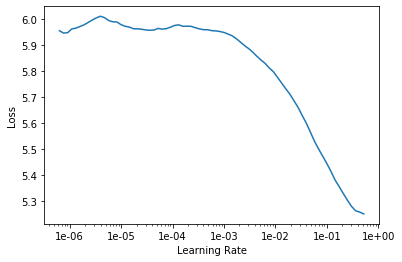

In [40]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

### Initial model training

Time to run:

* Full data set took about 13 hours using the Nvidia P1000
* Full data set was predicted to take about 25 hours with the T4
* 10% data took about 1 hour (1:08) using the Nvidia P1000
* 10% data is predicted to take about 2.5 hour (actual 2:42) using the Nvidia GTX 1060


In [41]:
release_mem()

In [42]:
# no idea how long nor how much resources this will take
# not sure 1e-2 is the right learning rate; maybe 1e-1 or between 1e-2 and 1e-1
# using t4
# progress bar says this will take around 24 hours... ran for about 52 minutes
# gpustat/nvidia-smi indicates currently only using about 5GB of GPU RAM
# using p100
# progress bar says this will take around 12 hours; took 13:16
# at start GPU using about 5GB RAM
# after about 8 hours GPU using about 7.5GB RAM.
# looks like I could increase batch size...
# with bs=64, still only seems to be using about 7GB GPU RAM after running for 15 minutes. 
# will check after a bit, but likely can increase batch size further

if os.path.isfile(str(init_model_file) + '.pth'):
    learn.load(init_model_file)
    print('loaded learner')
else:
    learn.fit_one_cycle(1, 5e-2, moms=(0.8,0.7))
    learn.save(init_model_file)
    print('generated new learner')

epoch,train_loss,valid_loss,accuracy,time
0,2.628462,2.492367,0.530601,10:59


generated new learner


In [43]:
release_mem()

continue from initial training - reload in case just want to continue processing from here.

As an FYI pytorch automatically appends .pth to the filename, you cannot provide it

In [44]:
#learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
#learn.load(init_model_file)
#print('done')

In [45]:
learn.show_results()

text,target,pred
xxbos xxmaj resp xxmaj care xxmaj note : \n \n xxmaj pt cont trached on cool mist aerosol as,per xxmaj carevue . xxmaj lung sounds coarse dim @ bases suct xxunk th pale yellow sput . xxmaj pt,"well carevue carevue . xxmaj pt sounds are , in bases . sm sm . yellow . . xxmaj pt"
: \n xxmaj swan - xxmaj ganz catheter with tip at the periphery of the central pulmonary artery .,\n xxmaj new right internal jugular venous catheter with the tip in the lower superior \n vena cava,\n xxmaj xxmaj pt right subclavian jugular line catheter tip tip tip in the right \n vena vena
". \n xxup issues : \n - xxup tbm , s / p xxunk and posterior tracheal splinting",via r \n thoracotomy [ * * 1 - 23 * * ] \n - subcutaneous emphysema \n,"\n , xxup fem thoracotomy , * * xxmaj - 28 * * ] . xxup xxmaj xxup \n"
\n 30 \n 31 \n xxmaj glucose \n 156 \n 94 \n 75 \n,110 \n 85 \n xxmaj other labs : xxup pt / xxup ptt / xxup inr:13.6 / 32.1,"xxup : xxup pt / xxup ptt / xxup xxunk / 1.2 / 1.2 , xxup ck / xxup ckmb"
xxmaj midazolam ( xxmaj versed ) - [ * * 2111 - 12 - 7 * * ] 05:30 xxup,am \n xxmaj fentanyl - [ * * 2111 - 12 - 7 * * ] 05:30 xxup am,am \n xxup ventilator : [ * * xxmaj - 2 - 26 * * ] 10:00 xxup am


In [53]:
prev_cycles = 0

if os.path.isfile(cycles_file):
    with open(cycles_file, 'rb') as f:
        prev_cycles = pickle.load(f)
print('This model has been trained for', prev_cycles, 'epochs already')

This model has been trained for 4 epochs already


### Now fine tune language model

Performance notes w/P100 GPU:

* at batch size of 128 takes about 1:14:00 per epoch; GPU usage is about 14GB; RAM usage is about 10GB
* at batch size of 96 takes about 1:17:00 per epoch; GPU usage is about  9GB; RAM usage is about 10GB
* at batch size of 48 takes about 1:30:00 per epoch; GPU usage is about  5GB; RAM usage is about 10GB

With `learn.fit_one_cycle(8, 5e-3, moms=(0.8,0.7))` (8 cycles)
* gets from about 62.7% accuracy to 67.6% accuracy
* Total time: 9:54:16


    epoch 	train_loss 	valid_loss 	accuracy 	time
    0 	1.926960 	1.832659 	0.627496 	1:14:14
    1 	1.808083 	1.755725 	0.637424 	1:14:15
    2 	1.747903 	1.697741 	0.645431 	1:14:15
    3 	1.714081 	1.652703 	0.652703 	1:14:19
    4 	1.637801 	1.602961 	0.660170 	1:14:15
    5 	1.596906 	1.553225 	0.668557 	1:14:14
    6 	1.572020 	1.519172 	0.674477 	1:14:26
    7 	1.517364 	1.510010 	0.676342 	1:14:14


Output from first 3 runs:

    epoch 	train_loss 	valid_loss 	accuracy 	time
        0 	1.828720 	1.741310 	0.646276 	3:03:05

     1 addtional run of fit_one_cycle complete

    epoch 	train_loss 	valid_loss 	accuracy 	time
        0 	1.736914 	1.701096 	0.652299 	3:03:00

     2 addtional run of fit_one_cycle complete

    epoch 	train_loss 	valid_loss 	accuracy 	time
        0 	1.699437 	1.677218 	0.655742 	3:03:02

     3 addtional run of fit_one_cycle complete
    completed 3 new training epochs
    completed 3 total training epochs
    
Output from next 4 runs:

    loaded existing learner from /home/seth/mimic/mimic_lm_fine_tuned_3

    epoch 	train_loss 	valid_loss 	accuracy 	time
        0 	1.693833 	1.664847 	0.658170 	3:03:05

         1 addtional run of fit_one_cycle complete

    epoch 	train_loss 	valid_loss 	accuracy 	time
        0 	1.745765 	1.653829 	0.659691 	3:02:57

         2 addtional run of fit_one_cycle complete

    epoch 	train_loss 	valid_loss 	accuracy 	time
        0 	1.741647 	1.648660 	0.660596 	3:02:53

         3 addtional run of fit_one_cycle complete

    epoch 	train_loss 	valid_loss 	accuracy 	time
        0 	1.672191 	1.643600 	0.661175 	3:02:40

         4 addtional run of fit_one_cycle complete
    completed 4 new training epochs
    completed 7 total training epochs

Output from next 4 runs:

    loaded existing learner from /home/seth/mimic/mimic_lm_fine_tuned_7

    epoch 	train_loss 	valid_loss 	accuracy 	time
        0 	1.701067 	1.638409 	0.661831 	3:02:46

         1 addtional run of fit_one_cycle complete

    epoch 	train_loss 	valid_loss 	accuracy 	time
        0 	1.672565 	1.636598 	0.662079 	3:02:55

         2 addtional run of fit_one_cycle complete

    epoch 	train_loss 	valid_loss 	accuracy 	time
        0 	1.715523 	1.635751 	0.662418 	3:03:00

         3 addtional run of fit_one_cycle complete

    epoch 	train_loss 	valid_loss 	accuracy 	time
        0 	1.682663 	1.632025 	0.662714 	3:02:57

         4 addtional run of fit_one_cycle complete
    completed 4 new training epochs
    completed 11 total training epochs




In [64]:
print('now testing with differnt learning rate 5e-2')

# if want to continue training existing model, set to True
# if want to start fresh from the initialized language model, set to False
# also, make sure to remove any previously created saved states before changing
# flag back to continue
continue_flag = True
########################################################
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

if continue_flag:
    # mostly a duplicate of the previous cell, but necessary to make sure if just this cell
    # is run, everything works correctly in continue mode
    if os.path.isfile(cycles_file):
        with open(cycles_file, 'rb') as f:
            prev_cycles = pickle.load(f)
        print('This model has been trained for', prev_cycles, 'epochs already')    
    file = lm_base_file + str(prev_cycles)
    learner_file = base_path/file
    if os.path.isfile(str(learner_file) + '.pth'):
        learn.load(learner_file)
        print('loaded existing learner from', str(learner_file))
    else:
        # should not continue as could not find specified file
        print('existing learner file (', learner_file, 'not found')
        assert(False)
else:
    prev_cycles = 0

########################################################
# set this to how many additional cycles you want to run
########################################################
num_cycles = 4
########################################################

# learn.fit_one_cycle(4, 5e-2, moms=(0.8,0.7))
# print('    ', n + 1, 'addtional run of fit_one_cycle complete')
# file = lm_base_file + str(prev_cycles + n + 1)
# learner_file = base_path/file
# learn.save(learner_file)
# with open(cycles_file, 'wb') as f:
#     pickle.dump(prev_cycles + n + 1, f)
# release_mem()


for n in range(num_cycles):
    learn.fit_one_cycle(1, 5e-2, moms=(0.8,0.7))
    print('    ', n + 1, 'addtional run of fit_one_cycle complete')
    file = lm_base_file + str(prev_cycles + n + 1)
    learner_file = base_path/file
    learn.save(learner_file)
    with open(cycles_file, 'wb') as f:
        pickle.dump(prev_cycles + n + 1, f)
    release_mem()
    
print('completed', num_cycles, 'new training epochs')
print('completed', num_cycles + prev_cycles, 'total training epochs')

now testing with differnt learning rate 5e-2
This model has been trained for 4 epochs already
loaded existing learner from /home/seth/mimic/mimic_lm_fine_tuned_4


epoch,train_loss,valid_loss,accuracy,time
0,1.997188,1.990023,0.607164,10:56


     1 addtional run of fit_one_cycle complete


epoch,train_loss,valid_loss,accuracy,time
0,2.023669,1.993085,0.607259,10:55


     2 addtional run of fit_one_cycle complete


epoch,train_loss,valid_loss,accuracy,time
0,1.949204,1.991918,0.607305,10:54


     3 addtional run of fit_one_cycle complete


epoch,train_loss,valid_loss,accuracy,time
0,1.970876,1.991939,0.606908,10:54


     4 addtional run of fit_one_cycle complete
completed 4 new training epochs
completed 8 total training epochs


In [63]:
with open(cycles_file, 'wb') as f:
    pickle.dump(4, f)

epoch,train_loss,valid_loss,accuracy,time
0,1.926960,1.832659,0.627496,1:14:14
1,1.808083,1.755725,0.637424,1:14:15
2,1.747903,1.697741,0.645431,1:14:15
3,1.714081,1.652703,0.652703,1:14:19
4,1.637801,1.602961,0.660170,1:14:15
5,1.596906,1.553225,0.668557,1:14:14
6,1.572020,1.519172,0.674477,1:14:26
7,1.517364,1.510010,0.676342,1:14:14


In [24]:
fn_pattern = lm_base_file + '*'
training_files = glob.glob(str(base_path/fn_pattern))
training_files.sort()
training_files

['/home/jupyter/mimic/mimic_lm_fine_tuned_3.pth']

In [ ]:
# need to load the last file
learn.load(training_files[-1])

In [20]:
# test the language generation capabilities of this model (not the point, but is interesting)
TEXT = "For confirmation, she underwent CTA of the lung which was negative for pulmonary embolism"
N_WORDS = 40
N_SENTENCES = 2
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

For confirmation, she underwent CTA of the lung which was negative for pulmonary embolism 
  but showed no PE , but did show some pulmonary edema . She has had 
  some mild dyspnea on exertion but has improved . She was brought to the 
  ED for further evaluation
For confirmation, she underwent CTA of the lung which was negative for pulmonary embolism or dissection . 
  She was extubated today and given 1 unit of prbcs for Hct of 24 . She is 
  afebrile , HR in the 120s , BP stable . She is


In [21]:
learn.save_encoder(enc_file)

To load the encoder:

```python
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
learn.load_encoder(enc_file)
```

## Now based on our language model, train a classifier

In [ ]:
class_file = 'mimic_cl.pickle'
filename = base_path/class_file

if os.path.isfile(filename):
    data_cl = load_data(base_path, file, bs=bs)
else:
    data_cl = (TextList.from_df(df, cols='', vocab=data_lm.vocab)
               #grab all the text files in path
               .split_by_folder(valid='test')
               #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
               .label_from_folder(classes=['neg', 'pos'])
               #label them all with their folders
               .databunch(bs=bs))

data_cl.save(filename)

In [28]:
df.head()

NameError: name 'df' is not defined

In [ ]:
data_cl.show_batch()

In [36]:
len(df.CATEGORY.unique())

15

In [37]:
len(df.DESCRIPTION.unique())

1676

In [ ]:
if os.path.isfile(filename):
    data_lm = load_data(base_path, file, bs=bs)
else:
    data_lm = (TextList.from_df(df, 'texts.csv', cols='TEXT')
               #df has several columns; actual text is in column TEXT
               .split_by_rand_pct(valid_pct=valid_pct, seed=seed)
               #We randomly split and keep 10% for validation
               .label_from_df(cols='DESCRIPTION')
               #We want to do a language model so we label accordingly
               .databunch(bs=bs))
    data_lm.save(filename)

This is the version from the original example
```python
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')
```

In [ ]:
learn = text_classifier_learner(data_cl, AWD_LSTM, drop_mult=0.5)
learn.load_encoder(enc_file)

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

Change learning rate based on results from the above plot

In [ ]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))